<a href="https://colab.research.google.com/github/huubinh49/clothing-detection/blob/main/Clothing_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [ ]:
import os
os.chdir("/content/Mask_RCNN")

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install keras==2.1.5 #rerun cho đến khi cài được keras 2.1.5

In [ ]:
!python3 setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
adding license file 'LICENSE' (matched pattern 'LICEN

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")
from importlib.machinery import SourceFileLoader

# Import Mask RCNN
sys.path.insert(0, ROOT_DIR) 
from mrcnn.config import Config
from mrcnn import utils
modellib = SourceFileLoader('model', os.path.join(ROOT_DIR, 'mrcnn/model.py')).load_module()
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = '/content/gdrive/MyDrive/dataset/'

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [ ]:
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

############################################################
#  Configurations
############################################################


class ClothingConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "clothes"
    BACKBONE = 'resnet101'
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # Background + clothes

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 30
    BATCH_SIZE = 4
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 1

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.6

    IMAGE_MAX_DIM    =  512
    IMAGE_MIN_DIM    = 512
    RPN_ANCHOR_SCALES   =    (16,32,64,128, 256)
    RPN_ANCHOR_RATIOS =[1, 1.5, 2]   
    RPN_ANCHOR_STRIDE=1
    RPN_TRAIN_ANCHORS_PER_IMAGE= 200

    DETECTION_MAX_INSTANCES=4
    TRAIN_ROIS_PER_IMAGE = 200
    LEARNING_RATE = 0.001 
    #USE_MINI_MASK = False       

    # Image mean (RGB)
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])
    MAX_GT_INSTANCES=4
config = ClothingConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        4
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
import zipfile
os.makedirs("/tmp/dataset/train")
os.makedirs("/tmp/dataset/val")

In [ ]:
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/dataset/train.zip", 'r')
zip_ref.extractall("/tmp/dataset/train/")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/dataset/testing.zip", 'r')
zip_ref.extractall("/tmp/dataset/val/")
zip_ref.close()

In [ ]:
class ClothingDataset(utils.Dataset):

    def load_clothes(self, dataset_dir, subset):
        """
        """
        name_dict = {
                          "short_sleeved_shirt" : 1,
                          "long_sleeved_shirt" : 2,
                          "short_sleeved_outwear" : 3,
                          "long_sleeved_outwear" : 4,
                          "vest" : 5,
                          "sling" : 6,
                          "shorts" : 7,
                          "trousers" : 8,
                          "skirt" : 9,
                          "short_sleeved_dress" : 10,
                          "long_sleeved_dress" : 11,
                          "vest_dress" : 12,
                          "sling_dress" : 13
        }
        # Add classes. We have only one class to add.
        for name, idx in name_dict.items():
          self.add_class("clothes", idx, name)

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        
        annotations = json.load(open(os.path.join(dataset_dir, "via_reg_data.json")))
        annotations = list(annotations.values()) 
        print(subset, len(annotations))
        
        annotations = [a for a in annotations if a['regions']]
        dataset_img = os.path.join(dataset_dir, 'image')
        
        # Add images
        
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a["regions"]]
            objects = [r['region_attributes']['clothes']  for r in a["regions"] if len(r['region_attributes'])]
         
            # key = tuple(name_dict)
            num_ids = [int(a) for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_img, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "clothes",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "clothes":
            return super(self.__class__, self).load_mask(image_id)
        mask = np.zeros((info["height"], info["width"], len(info["polygons"])), dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            rr[rr > mask.shape[0]-1] = mask.shape[0]-1
            cc[cc > mask.shape[1]-1] = mask.shape[1]-1
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(info["num_ids"], dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "clothes":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [ ]:
#Load dataset
dataset_dir = "/tmp/dataset/"
# Training dataset.
dataset_train = ClothingDataset()
dataset_train.load_clothes(dataset_dir, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = ClothingDataset()
dataset_val.load_clothes(dataset_dir, "val")
dataset_val.prepare()


train 50068
val 38394


In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=DEFAULT_LOGS_DIR)
weights_path = '/content/gdrive/MyDrive/dataset/mask_rcnn_coco.h5'

def train(model, weights_path, lr = 0.001, epochs = 5, layers = "heads", init_with = "last"):
  if not os.path.exists(weights_path):
      utils.download_trained_weights(weights_path)

  if init_with == "coco":
      model.load_weights(COCO_MODEL_PATH, by_name=True,
                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                  "mrcnn_bbox", "mrcnn_mask"])  
  elif init_with == "last":
      # Load the last model you trained and continue training
      model.load_weights(weights_path, by_name=True)
  
  model.train(dataset_train, dataset_val,
                learning_rate=lr,
                epochs=epochs,
                layers='heads')
  model.keras_model.save_weights(weights_path)
#train(model, weights_path)

In [ ]:
class InferenceConfig(ClothingConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# Load trained weights
print("Loading weights from ", '/content/gdrive/MyDrive/dataset/mask_rcnn_coco.h5')
model.load_weights('/content/gdrive/MyDrive/dataset/mask_rcnn_coco.h5', by_name=True)

Loading weights from  /content/gdrive/MyDrive/dataset/mask_rcnn_coco.h5


  0%|          | 0/36179 [00:00<?, ?it/s]

Processing 1 images
image                    shape: (1224, 790, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max: 1224.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


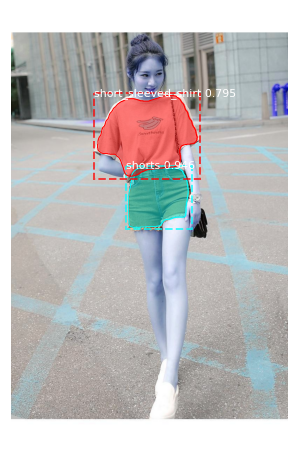

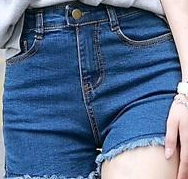

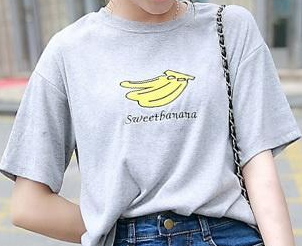

  0%|          | 0/36179 [00:00<?, ?it/s]


In [ ]:
from google.colab.patches import cv2_imshow
from tqdm import tqdm
class_names = [ "background","short_sleeved_shirt",
                          "long_sleeved_shirt", 
                          "short_sleeved_outwear",
                          "long_sleeved_outwear",
                          "vest",
                          "sling",
                          "shorts",
                          "trousers",
                          "skirt",
                          "short_sleeved_dress",
                          "long_sleeved_dress",
                          "vest_dress",
                          "sling_dress"]

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
list_images = os.listdir('/tmp/dataset/val/image/')
for image_id in tqdm(list_images[2215:]):
  original_image = cv2.imread('/tmp/dataset/val/image/{}'.format(image_id))

  image_input = original_image
  image_input = cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB)
  
  r = model.detect([image_input], verbose=1)
  # Get the results for the first image.
  r = r[0]
  if len(r['rois']):
  # Visualize the detected objects.
    visualize.display_instances(image=original_image, 
                                    boxes=r['rois'], 
                                    masks=r['masks'], 
                                    class_ids=r['class_ids'], 
                                    class_names = class_names, figsize=(8, 8),
                                    scores=r['scores'])
    for i in range(len(r['rois'])):
      rois = r['rois'][i]
      img = cv2.imread('/tmp/dataset/val/image/{}'.format(image_id))
      bb_img = img[rois[0]:rois[2], rois[1]:rois[3], :]
      cv2_imshow(bb_img)
  break